In [1]:
import pandas as pd
import numpy as np
import argparse
import logging
import math

In [2]:
from simulator import loadBeneficiaryData, getTopk, takeActions, getWhittleIndex


In [72]:
from jupyterthemes import jtplot

# choose which theme to inherit plotting style from
# onedork | grade3 | oceans16 | chesterish | monokai | solarizedl | solarizedd
jtplot.style(theme='grade3')

In [3]:
T_data, w, engagement_matrix, cluster_ids = loadBeneficiaryData()


/Users/vermashresth/opt/anaconda3/lib/python3.8/site-packages/sklearn/base.py:310: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 0.23.2 when using version 0.24.2. This might lead to breaking code or invalid results. Use at your own risk.
  warnings.warn(
/Users/vermashresth/opt/anaconda3/lib/python3.8/site-packages/sklearn/base.py:310: UserWarning: Trying to unpickle estimator RandomForestClassifier from version 0.23.2 when using version 0.24.2. This might lead to breaking code or invalid results. Use at your own risk.
  warnings.warn(


In [4]:
def nck(n, k):
    return math.factorial(n)/(math.factorial(k)*math.factorial(n-k))

def print_r(text, p):
    dice = np.random.random()
    if dice<p:
        print(text)

In [5]:
policy_names={0:'random',1:'rr', 2:'whittle'}
policy_map = {policy_names[key]:key for key in policy_names}
    
def runSimulation(args, T=None, w=None):
  E_START_STATE_PROB=0.5
  ##### Unpack arguments
  L=args.simulation_length
  N=args.num_beneficiaries
  k=args.num_resources
  ntr=args.num_trials
  
  policies=[0, 1, 2]

  state_record=np.zeros((ntr, len(policies),N,L))  # Store the full state
                                                   # trajectory
  simulated_rewards=np.zeros((ntr, len(policies))) # Store aggregate rewards
  history_dict = {i_pol: [] for i_pol in policies}
  
  traj = []
  ##### Iterate over number of independent trials to average over
  for tr in range(ntr):
    tr_traj = []
    ## Initialize for each trial
    np.random.seed(seed=tr+args.seed_base)
     # Random state \
    #initialization                      
    
    ## For current trial, evaluate all policies
    for pol_idx, pol in enumerate(policies):
      pol_traj = []
      states=np.random.binomial(1, E_START_STATE_PROB, size=N)
      ## Iterate over timesteps. Note that if simulation length is L, 
      ## there are L-1 action decisions to take.
      for timestep in range(L-1):
        tupl = []
        ## Compute actions
        state_record[tr, pol_idx, :, timestep] = np.copy(states)
        tupl.append(np.copy(states))
        
        actions=getActions(states=states, policy=pol, ts=timestep, w=w, k=k)
        tupl.append(actions)

        states = np.copy(takeActions(states, T, actions))
        tupl.append(states)
        tupl.append(np.copy(state_record[tr, pol_idx, :, timestep]))
        pol_traj.append(tupl)

      simulated_rewards[tr, pol_idx]=np.sum(np.sum(state_record[tr,pol_idx], \
                                                    axis=1))

      tr_traj.append(pol_traj)
    traj.append(tr_traj)
  ##### Print results
  for pol in policies: 
    print("Expected reward of policy %s is %s"%(policy_names[pol], \
                            np.mean(simulated_rewards[:,policies.index(pol)])))
  
  return simulated_rewards, state_record, np.array(traj)


In [141]:
def getActions(states, policy, ts, w, k):
    N = len(states)
    actions=np.zeros(N)
    if policy == 0:
        # Select k arms at random
        actions[np.random.choice(np.arange(len(states)), k)] = 1
    elif policy == 1:
        # Select k arms in round robin
        actions[[(ts*k+i)%N for i in range(k)]] = 1
    elif policy == 2:
        # select k arms by Whittle
        N = len(states)
        actions=np.zeros(N)
        whittle_indices=w[np.arange(N), states]

        top_k_whittle=getTopk(whittle_indices, k)
        actions[top_k_whittle]=1
    return actions

In [139]:

def getActionProbDefault(states, action, policy):
    return 0.5

def getActionProbFrequentist(traj, state, action, benef, ts, policy, min_support = 1):
    s_t = traj[:, # trial index
        policy, # policy index
        ts, # time index
        dim_dict['state'], # tuple dimension
        : # benef index
        ]
    state_match_bool = (np.expand_dims(state, axis=0) == s_t).sum(axis=1)==\
                        traj.shape[4] 
    action_match_bool = traj[:, # trial index
        policy, # policy index
        ts, # time index
        dim_dict['action'], # tuple dimension
        benef # benef index
        ] == action
    if state_match_bool.sum()<min_support:
        return 0
        return getActionProbDefault(state, action, policy)
    else:
        prob = (state_match_bool & action_match_bool).sum()/state_match_bool.sum()
        return prob
    
def getActionProb(states, action, policy, benef, ts=None, w=None, k=None, N=None):
    if policy==policy_map['random']:
        return getActionProbRandom(states, action, k, N)
    elif policy==policy_map['rr']:
        return getActionProbRandom(states, action, k, N)
    elif policy==policy_map['whittle']:
        return getActionProbWhittle(states, action, benef, w, k, N)
    else:
        raise f'Policy {policy} not supported'
    
def getActionProbWhittle(states, action, benef, w, k, N):
    WHITTLE_EPS = 1e-2
#     N = len(states)
    whittle_actions = getActions(states, policy_map['whittle'], ts, w, k)
    if whittle_actions[benef]==action:
        return 1-WHITTLE_EPS
    else:
        return WHITTLE_EPS*k/(N-k)

def getActionProbRandom(states, action, k, N):
    ## select k arms according to whittle indices
    N = len(states)
#     return nck(N-1, k-1)/nck(N, k)
    if action:
        return k/N
    else:
        return 1-k/N



n_benefs=20, k = 3, n_trials=1, T = 10, 20, 30, 40
n_benefs=20, k = 3, T=40, n_trials=1, 10, 100, 1000 


In [8]:
[[39, 50, 28, 11],
 [77, 96, 197, 11],
 [121, 142, 91, 11],
 [207, 239, 19, 11] ]

[[46, 61, 73, 12],
]


[[46, 61, 73, 12]]

In [9]:
import numpy as np

In [43]:
n_benefs = 10
T = 5
K = 3
n_trials = 10
gamma = 1
sim_mat = np.random.uniform(0, 1, (n_benefs, n_benefs))

# state - (0, 1)
# action - (0, 1)
# reward - (0, 1)
# n_traj x n_benefs x T_timesteps x 4 (state, act, new_state, rew)


parser = argparse.ArgumentParser(description='Inputs to engagement simulator module')
parser.add_argument('-N', '--num_beneficiaries', default=7000, type=int, help='Number of Beneficiaries')
parser.add_argument('-k', '--num_resources', default=1400, type=int, help='Number of calls available per day')
parser.add_argument('-L', '--simulation_length', default=40, type=int, help='Number of timesteps of simulation')
parser.add_argument('-ntr', '--num_trials', default=10, type=int, help='Number of independent trials')
parser.add_argument('-s', '--seed_base', default=10, type=int, help='Seedbase for numpy. This is starting seedbase. Simulation will consider the seeds= {seed_base, ... seed_base+ntr-1}')
parser.add_argument('-p', '--policy', default=-1, type=int, help='policy to run. default is all policies')
parser.add_argument("-f", "--fff", help="a dummy argument to fool ipython", default="1")
args = parser.parse_args()
args.num_beneficiaries=n_benefs
args.num_resources=K
args.simulation_length=T
args.num_trials=n_trials

np.random.seed(args.seed_base)
mask = np.random.choice(np.arange(T_data.shape[0]), n_benefs)
print(mask[:10])
simulated_rewards, state_record, traj = runSimulation(args, T=T_data[mask], w=w[mask])
print('trajectory shape: ', np.array(traj).shape) 
# shape: trial * n_pol * T-1 * n_benefs


[1289 7293 4623 1344 3441 7291 1180 2009 4829 1520]
Expected reward of policy random is 12.2
Expected reward of policy rr is 13.8
Expected reward of policy whittle is 13.3
trajectory shape:  (10, 3, 4, 4, 10)


In [151]:
def get_sim_results(n_benefs = 10, T = 5, K = 3, n_trials = 10, gamma = 1, debug=False):
    parser = argparse.ArgumentParser(description='Inputs to engagement simulator module')
    parser.add_argument('-N', '--num_beneficiaries', default=7000, type=int, help='Number of Beneficiaries')
    parser.add_argument('-k', '--num_resources', default=1400, type=int, help='Number of calls available per day')
    parser.add_argument('-L', '--simulation_length', default=40, type=int, help='Number of timesteps of simulation')
    parser.add_argument('-ntr', '--num_trials', default=10, type=int, help='Number of independent trials')
    parser.add_argument('-s', '--seed_base', default=10, type=int, help='Seedbase for numpy. This is starting seedbase. Simulation will consider the seeds= {seed_base, ... seed_base+ntr-1}')
    parser.add_argument('-p', '--policy', default=-1, type=int, help='policy to run. default is all policies')
    parser.add_argument("-f", "--fff", help="a dummy argument to fool ipython", default="1")
    args = parser.parse_args()
    args.num_beneficiaries=n_benefs
    args.num_resources=K
    args.simulation_length=T
    args.num_trials=n_trials

    np.random.seed(args.seed_base)
    mask = np.random.choice(np.arange(T_data.shape[0]), n_benefs)

    simulated_rewards, state_record, traj = runSimulation(args, T=T_data[mask], w=w[mask])

    if debug:
        print(mask[:10])
        print('trajectory shape: ', np.array(traj).shape) 
    whittle_rew = simulated_rewards[:, 2].mean()
    return traj, whittle_rew, simulated_rewards, mask

In [152]:
def ope(traj, mask, n_benefs, T, K, n_trials, gamma):
    compare = {'target':2, 'beh':0}
    dim_dict = {'state':0, 'action':1, 'new_state':2, 'reward':3}
    gamma_series = np.array([gamma**(t-1) for t in range(T-1)])

    v = []
    for benef in range(n_benefs):
        v_i = 0
        for trial in range(n_trials):
            imp_weight = 1
            v_i_tau = 0
            for ts in range(T-1):
                a_i_t = traj[trial, # trial index
                                compare['beh'], # policy index
                                ts, # time index
                                dim_dict['action'], # tuple dimension
                                benef # benef index
                                ].astype(int)

                s_t = traj[trial, # trial index
                                compare['beh'], # policy index
                                ts, # time index
                                dim_dict['state'], # tuple dimension
                                : # benef index
                                ].astype(int)
                pi_tar = getActionProb(s_t, a_i_t,
                                           policy=compare['target'],
                                           benef=benef, ts=ts,
                                           w=w[mask], k=K, N=n_benefs)
                pi_beh = getActionProb(s_t, a_i_t,
                                           policy=compare['beh'],
                                           benef=benef, ts=ts,
                                           w=w[mask], k=K, N=n_benefs)
                imp_weight*= pi_tar/pi_beh
                v_i_t_tau = gamma_series[ts] * traj[trial, # trial index
                                                compare['beh'], # policy index
                                                ts, # time index
                                                dim_dict['reward'], # tuple dimension
                                                benef # benef index
                                                ] * imp_weight
                v_i_tau += v_i_t_tau
            v_i += v_i_tau
        v.append(v_i/n_trials)
    ope = np.sum(v)
    print(f'OPE: {ope}')
    return ope

In [153]:
n_benefs = 10
T = 5
K = 3
n_trials = 1
gamma = 1
traj, sim_whittle, simulated_rewards, mask = get_sim_results(n_benefs, T, K, n_trials, gamma)
ope_whittle = ope(traj, mask, n_benefs, T, K, n_trials, gamma)

Expected reward of policy random is 13.0
Expected reward of policy rr is 12.0
Expected reward of policy whittle is 8.0
OPE: 18.29950038674362


Expected reward of policy random is 13.0
Expected reward of policy rr is 12.0
Expected reward of policy whittle is 8.0
OPE: 18.29950038674362
Expected reward of policy random is 12.6
Expected reward of policy rr is 13.2
Expected reward of policy whittle is 12.6
OPE: 10.330057108177716
Expected reward of policy random is 12.2
Expected reward of policy rr is 13.8
Expected reward of policy whittle is 13.3
OPE: 9.932264339943393
Expected reward of policy random is 13.75
Expected reward of policy rr is 13.3
Expected reward of policy whittle is 13.4
OPE: 13.269863501474726
Expected reward of policy random is 13.13
Expected reward of policy rr is 13.25
Expected reward of policy whittle is 13.83
OPE: 13.452756286491416
Expected reward of policy random is 13.38
Expected reward of policy rr is 13.245
Expected reward of policy whittle is 14.155
OPE: 13.651626866015848
Expected reward of policy random is 13.443
Expected reward of policy rr is 13.3
Expected reward of policy whittle is 14.122
OPE: 1

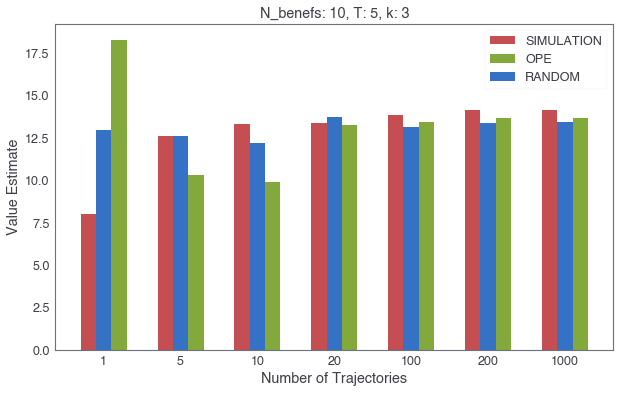

In [161]:
n_benefs = 10
T = 5
K = 3
gamma = 1

width = 0.2
trial_set = [1, 5, 10, 20, 100, 200, 1000]
plt.figure(figsize=(10, 6))
for idx, trials in enumerate(trial_set):
    traj, sim_whittle, simulated_rewards, mask = get_sim_results(n_benefs, T, K, trials, gamma)
    ope_whittle = ope(traj, mask, n_benefs, T, K, trials, gamma)
    sim_random = simulated_rewards[:, 0].mean()
    if idx == len(exp_set)-1:
        plt.bar(idx+1-width, sim_whittle, width=width, color='r', label='SIMULATION')
        plt.bar(idx+1+width, ope_whittle, width=width, color='g', label='OPE')
        plt.bar(idx+1, sim_random, width=width, color='b', label='RANDOM')
    else:
        plt.bar(idx+1-width, sim_whittle, width=width, color='r')
        plt.bar(idx+1+width, ope_whittle, width=width, color='g')
        plt.bar(idx+1, sim_random, width=width, color='b')
plt.grid(b=None)
plt.xticks(range(1, len(trial_set)+1), trial_set)
plt.ylabel('Value Estimate')
plt.xlabel('Number of Trajectories')
plt.title(f'N_benefs: {n_benefs}, T: {T}, k: {K}')
plt.legend()
print(sim_whittle, ope_whittle)

Expected reward of policy random is 13.4045
Expected reward of policy rr is 13.32
Expected reward of policy whittle is 14.116
OPE: 13.637565624581601
Expected reward of policy random is 26.6995
Expected reward of policy rr is 26.6315
Expected reward of policy whittle is 29.1775
OPE: 27.973172445835463
Expected reward of policy random is 39.93
Expected reward of policy rr is 40.3515
Expected reward of policy whittle is 44.3395
OPE: 33.76698624287004
Expected reward of policy random is 53.2225
Expected reward of policy rr is 53.7205
Expected reward of policy whittle is 59.3475
OPE: 37.06517419534336
Expected reward of policy random is 66.3765
Expected reward of policy rr is 66.9905
Expected reward of policy whittle is 74.2495
OPE: 38.79627471373428
Expected reward of policy random is 79.632
Expected reward of policy rr is 80.674
Expected reward of policy whittle is 89.33
OPE: 39.12190405377136
89.33 39.12190405377136


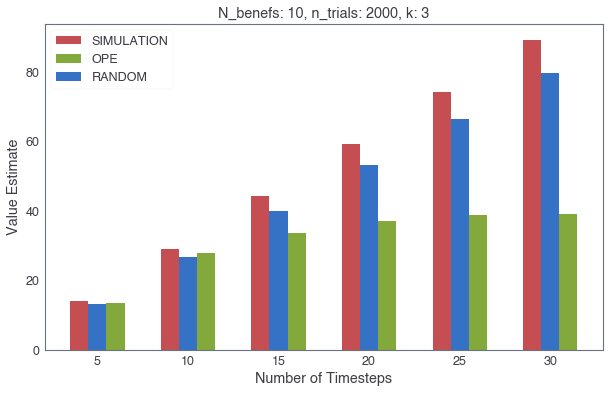

In [163]:
n_benefs = 10
K = 3
gamma = 1
n_trials = 2000

width = 0.2
T_set = [5, 10, 15, 20, 25, 30]
plt.figure(figsize=(10, 6))
for idx, time in enumerate(T_set):
    traj, sim_whittle, simulated_rewards, mask = get_sim_results(n_benefs, time, K, n_trials, gamma)
    ope_whittle = ope(traj, mask, n_benefs, time, K, n_trials, gamma)
    sim_random = simulated_rewards[:, 0].mean()
    if idx == len(exp_set)-1:
        plt.bar(idx+1-width, sim_whittle, width=width, color='r', label='SIMULATION')
        plt.bar(idx+1+width, ope_whittle, width=width, color='g', label='OPE')
        plt.bar(idx+1, sim_random, width=width, color='b', label='RANDOM')
    else:
        plt.bar(idx+1-width, sim_whittle, width=width, color='r')
        plt.bar(idx+1+width, ope_whittle, width=width, color='g')
        plt.bar(idx+1, sim_random, width=width, color='b')
plt.grid(b=None)
plt.xticks(range(1, len(T_set)+1), T_set)
plt.ylabel('Value Estimate')
plt.xlabel('Number of Timesteps')
plt.title(f'N_benefs: {n_benefs}, n_trials: {n_trials}, k: {K}')
plt.legend()
print(sim_whittle, ope_whittle)

10
Expected reward of policy random is 13.75
Expected reward of policy rr is 13.3
Expected reward of policy whittle is 13.4
OPE: 13.269863501474726
50
Expected reward of policy random is 69.95
Expected reward of policy rr is 71.4
Expected reward of policy whittle is 76.8
OPE: 80.94850300907785
100
Expected reward of policy random is 143.55
Expected reward of policy rr is 141.1
Expected reward of policy whittle is 156.0
OPE: 137.3438900598144
200
Expected reward of policy random is 268.45
Expected reward of policy rr is 273.0
Expected reward of policy whittle is 299.95
OPE: 258.3347995605325
1000
Expected reward of policy random is 1274.25
Expected reward of policy rr is 1283.95
Expected reward of policy whittle is 1376.75
OPE: 1288.3414817530954
1376.75 1288.3414817530954


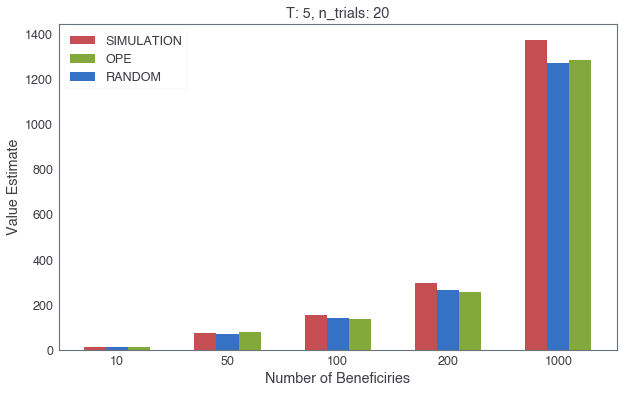

In [159]:

gamma = 1
n_trials = 20
T = 5

width = 0.2
exp_set = [10, 50, 100, 200, 1000]
K_set = [3, 16, 20, 40, 100]

plt.figure(figsize=(10, 6))
for idx, (n_benefs, K) in enumerate(zip(exp_set, K_set)):
    print(n_benefs)
    traj, sim_whittle, simulated_rewards, mask = get_sim_results(n_benefs, T, K, n_trials, gamma)
    ope_whittle = ope(traj, mask, n_benefs, T, K, n_trials, gamma)
    sim_random = simulated_rewards[:, 0].mean()
    if idx == len(exp_set)-1:
        plt.bar(idx+1-width, sim_whittle, width=width, color='r', label='SIMULATION')
        plt.bar(idx+1+width, ope_whittle, width=width, color='g', label='OPE')
        plt.bar(idx+1, sim_random, width=width, color='b', label='RANDOM')
    else:
        plt.bar(idx+1-width, sim_whittle, width=width, color='r')
        plt.bar(idx+1+width, ope_whittle, width=width, color='g')
        plt.bar(idx+1, sim_random, width=width, color='b')
plt.grid(b=None)
plt.xticks(range(1, len(exp_set)+1), exp_set)
plt.ylabel('Value Estimate')
plt.xlabel('Number of Beneficiries')
plt.title(f'T: {T}, n_trials: {n_trials}')
plt.legend()
print(sim_whittle, ope_whittle)

10
Expected reward of policy random is 82.0
Expected reward of policy rr is 85.0
Expected reward of policy whittle is 98.0
OPE: 18.35799425616735
50
Expected reward of policy random is 452.0
Expected reward of policy rr is 452.0
Expected reward of policy whittle is 509.0
OPE: 145.292835630022
100
Expected reward of policy random is 900.0
Expected reward of policy rr is 885.0
Expected reward of policy whittle is 1034.0
OPE: 273.99583783421684
200
Expected reward of policy random is 1605.0
Expected reward of policy rr is 1640.0
Expected reward of policy whittle is 1938.0
OPE: 1234.6739452279915
1000
Expected reward of policy random is 7618.0
Expected reward of policy rr is 7693.0
Expected reward of policy whittle is 8786.0
OPE: 6121.5869808035895
8786.0 6121.5869808035895


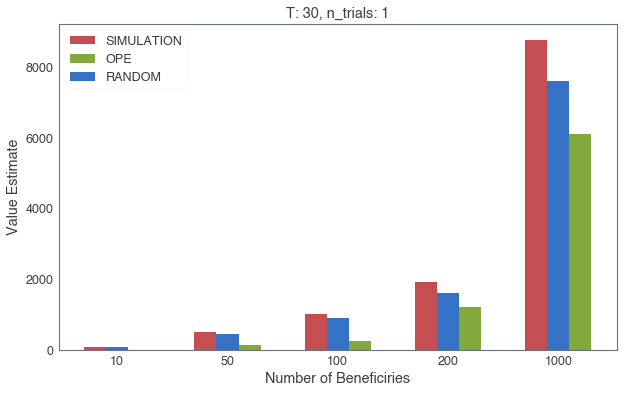

In [158]:

gamma = 1
n_trials = 1
T = 30

width = 0.2
exp_set = [10, 50, 100, 200, 1000]
K_set = [3, 16, 20, 40, 100]

plt.figure(figsize=(10, 6))
for idx, (n_benefs, K) in enumerate(zip(exp_set, K_set)):
    print(n_benefs)
    traj, sim_whittle, simulated_rewards, mask = get_sim_results(n_benefs, T, K, n_trials, gamma)
    ope_whittle = ope(traj, mask, n_benefs, T, K, n_trials, gamma)
    sim_random = simulated_rewards[:, 0].mean()
    if idx == len(exp_set)-1:
        plt.bar(idx+1-width, sim_whittle, width=width, color='r', label='SIMULATION')
        plt.bar(idx+1+width, ope_whittle, width=width, color='g', label='OPE')
        plt.bar(idx+1, sim_random, width=width, color='b', label='RANDOM')
    else:
        plt.bar(idx+1-width, sim_whittle, width=width, color='r')
        plt.bar(idx+1+width, ope_whittle, width=width, color='g')
        plt.bar(idx+1, sim_random, width=width, color='b')
plt.grid(b=None)
plt.xticks(range(1, len(exp_set)+1), exp_set)
plt.ylabel('Value Estimate')
plt.xlabel('Number of Beneficiries')
plt.title(f'T: {T}, n_trials: {n_trials}')
plt.legend()
print(sim_whittle, ope_whittle)

In [37]:
# del traj

In [38]:
#Idea: Stitch Trajectories starting from same state, action


## Whittle IS Estimate vs Random

In [57]:
compare = {'target':2, 'beh':0}
dim_dict = {'state':0, 'action':1, 'new_state':2, 'reward':3}
gamma_series = np.array([gamma**(t-1) for t in range(T-1)])

v = []
for benef in range(n_benefs):
    v_i = 0
    for trial in range(n_trials):
        imp_weight = 1
        v_i_tau = 0
        for ts in range(T-1):
            a_i_t = traj[trial, # trial index
                            compare['beh'], # policy index
                            ts, # time index
                            dim_dict['action'], # tuple dimension
                            benef # benef index
                            ].astype(int)
            
            s_t = traj[trial, # trial index
                            compare['beh'], # policy index
                            ts, # time index
                            dim_dict['state'], # tuple dimension
                            : # benef index
                            ].astype(int)
            pi_tar = getActionProb(s_t, a_i_t,
                                       policy=compare['target'],
                                       benef=benef, ts=ts,
                                       w=w[mask], k=K)
            pi_beh = getActionProb(s_t, a_i_t,
                                       policy=compare['beh'],
                                       benef=benef, ts=ts,
                                       w=w[mask], k=K)
            imp_weight*= pi_tar/pi_beh
            
#             print_r(f'weigh: {imp_weight},\
#                     pi_tar: {pi_tar}, pi_beh: {pi_beh}',  0.01) 
            v_i_t_tau = gamma_series[ts] * traj[trial, # trial index
                                            compare['beh'], # policy index
                                            ts, # time index
                                            dim_dict['reward'], # tuple dimension
                                            benef # benef index
                                            ] * imp_weight
            v_i_tau += v_i_t_tau
        v_i += v_i_tau
    v.append(v_i/n_trials)
ope = np.sum(v)
print(f'OPE: {ope}')

OPE: 9.932264339943393


## Whittle Weighted IS vs Random

In [687]:
compare = {'target':2, 'beh':0}
dim_dict = {'state':0, 'action':1, 'new_state':2, 'reward':3}
gamma_series = np.array([gamma**(t-1) for t in range(T-1)])
eps = 1e-5

v = []
for benef in range(n_benefs):
    v_i = 0
    imp_weight_sum = 0
    for trial in range(n_trials):
        v_i_tau = 0
        imp_weight = 1
        for ts in range(T-1):
            a_i_t = traj[trial, # trial index
                            compare['beh'], # policy index
                            ts, # time index
                            dim_dict['action'], # tuple dimension
                            benef # benef index
                            ].astype(int)
            
            s_t = traj[trial, # trial index
                            compare['beh'], # policy index
                            ts, # time index
                            dim_dict['state'], # tuple dimension
                            : # benef index
                            ].astype(int)
            pi_tar = getActionProb(s_t, a_i_t,
                                       policy=compare['target'],
                                       benef=benef, ts=ts,
                                       w=w[mask], k=k)
            pi_beh = getActionProb(s_t, a_i_t,
                                       policy=compare['beh'],
                                       benef=benef, ts=ts,
                                       w=w[mask], k=k)
            imp_weight*= pi_tar/pi_beh
            r_i_t_tau = traj[trial, # trial index
                                compare['beh'], # policy index
                                ts, # time index
                                dim_dict['reward'], # tuple dimension
                                benef # benef index
                            ]
            v_i_t_tau = gamma_series[ts] * r_i_t_tau * imp_weight
            imp_weight_sum += imp_weight
            v_i_tau += v_i_t_tau
        v_i += v_i_tau
    v.append(v_i/imp_weight_sum)
ope = np.sum(v)
print(f'WIS OPE: {ope}')

WIS OPE: 11.920399063208444


## Whittle Per Decision Weighted IS vs Random

In [624]:
compare = {'target':2, 'beh':0}
dim_dict = {'state':0, 'action':1, 'new_state':2, 'reward':3}
gamma_series = np.array([gamma**(t-1) for t in range(T-1)])
eps = 1e-5

v = []
imp_weight_dict = {}
for benef in range(n_benefs):
    for trial in range(n_trials):
        imp_weight_dict[(benef, trial, -1)] = 1
        
for ts in range(T-1):
    v_t = 0
    imp_weight_sum = 0
    for benef in range(n_benefs):
        for trial in range(n_trials):
            a_i_t = traj[trial, # trial index
                            compare['beh'], # policy index
                            ts, # time index
                            dim_dict['action'], # tuple dimension
                            benef # benef index
                            ].astype(int)
            
            s_t = traj[trial, # trial index
                            compare['beh'], # policy index
                            ts, # time index
                            dim_dict['state'], # tuple dimension
                            : # benef index
                            ].astype(int)
            
            pi_tar = getActionProb(s_t, a_i_t,
                                       policy=compare['target'],
                                       benef=benef, ts=ts,
                                       w=w[mask], k=k)
            pi_beh = getActionProb(s_t, a_i_t,
                                       policy=compare['beh'],
                                       benef=benef, ts=ts,
                                       w=w[mask], k=k)
            imp_weight_dict[(benef, trial, ts)] = imp_weight_dict[(benef, trial, ts-1)]*pi_tar/pi_beh
            r_i_t_tau = traj[trial, # trial index
                                compare['beh'], # policy index
                                ts, # time index
                                dim_dict['reward'], # tuple dimension
                                benef # benef index
                            ]
            v_i_t_tau = gamma_series[ts] * r_i_t_tau * imp_weight_dict[(benef, trial, ts)] 
            imp_weight_sum += imp_weight
            v_t += v_i_t_tau
    v.append(v_t/imp_weight_sum)
ope = np.sum(v)
print(f'WIS OPE: {ope}')

WIS OPE: 5.939270941552077e+98


In [632]:
imp_weight_dict[(3, 1, 5)]

1.0266106664456463e-12

## Sanity Check with 0.5,0.5

In [438]:
compare = {'target':0, 'beh':2}
dim_dict = {'state':0, 'action':1, 'new_state':2, 'reward':3}
gamma_series = np.array([gamma**(t-1) for t in range(T-1)])

v = []
for trial in range(n_trials):
    v_tau = 0
    for benef in range(n_benefs):
        imp_weight = 1
        v_i_tau = 0
        for ts in range(T-1):
            a_i_t = traj[trial, # trial index
                            compare['target'], # policy index
                            ts, # time index
                            dim_dict['action'], # tuple dimension
                            benef # benef index
                            ]
            
            s_t = traj[trial, # trial index
                            compare['target'], # policy index
                            ts, # time index
                            dim_dict['state'], # tuple dimension
                            : # benef index
                            ]
            
            imp_weight*= getActionProbDefault(s_t, a_i_t, compare['target'])/\
                        getActionProbDefault(s_t, a_i_t, compare['beh'])
            
            v_i_t_tau = gamma_series[ts] * traj[trial, # trial index
                                            compare['target'], # policy index
                                            ts, # time index
                                            dim_dict['reward'], # tuple dimension
                                            benef # benef index
                                            ] * imp_weight
            v_i_tau += v_i_t_tau
        v_tau += v_i_tau
    v.append(v_tau)
ope = np.mean(v)
print(ope)

13.448


In [387]:
v_i/imp_weight_sum

0.0364100668992518

In [301]:
compare = {'target':0, 'beh':1}
dim_dict = {'state':0, 'action':1, 'new_state':2, 'reward':3}
gamma_series = np.array([gamma**(t-1) for t in range(T-1)])
eps = 1e-5

v = []
for trial in range(n_trials):
    v_tau = 0
    for benef in range(n_benefs):
        imp_weight = 1
        v_i_tau = 0
        for ts in range(T-1):
            a_i_t = traj[trial, # trial index
                            compare['target'], # policy index
                            ts, # time index
                            dim_dict['action'], # tuple dimension
                            benef # benef index
                            ]
            
            s_t = traj[trial, # trial index
                            compare['target'], # policy index
                            ts, # time index
                            dim_dict['state'], # tuple dimension
                            : # benef index
                            ]
            
            imp_weight*= getActionProbFrequentist(traj, s_t, a_i_t,
                                                  benef, ts, compare['target'])/\
                        (getActionProbFrequentist(traj, s_t, a_i_t,
                                                  benef, ts, compare['beh'])+eps)
            
            v_i_t_tau = gamma_series[ts] * traj[trial, # trial index
                                            compare['target'], # policy index
                                            ts, # time index
                                            dim_dict['reward'], # tuple dimension
                                            benef # benef index
                                            ] * imp_weight
            v_i_tau += v_i_t_tau
        v_tau += v_i_tau
    v.append(v_tau)
ope = np.mean(v)
print(ope)

0 min sup not there
0 min sup not there
0 min sup not there
0 min sup not there
0 min sup not there
0 min sup not there
0 min sup not there
0 min sup not there
0 min sup not there
0 min sup not there
0 min sup not there
0 min sup not there
0 min sup not there
0 min sup not there
0 min sup not there
0 min sup not there
0 min sup not there
0 min sup not there
0 min sup not there
0 min sup not there
0 min sup not there
0 min sup not there
0 min sup not there
0 min sup not there
0 min sup not there
0 min sup not there
0 min sup not there
0 min sup not there
0 min sup not there
0 min sup not there
0 min sup not there
0 min sup not there
0 min sup not there
0 min sup not there
0 min sup not there
0 min sup not there
0 min sup not there
0 min sup not there
0 min sup not there
0 min sup not there
0 min sup not there
0 min sup not there
0 min sup not there
0 min sup not there
0 min sup not there
0 min sup not there
0 min sup not there
0 min sup not there
0 min sup not there
0 min sup not there


0 min sup not there
0 min sup not there
0 min sup not there
0 min sup not there
0 min sup not there
0 min sup not there
0 min sup not there
0 min sup not there
0 min sup not there
0 min sup not there
0 min sup not there
0 min sup not there
0 min sup not there
0 min sup not there
0 min sup not there
0 min sup not there
0 min sup not there
0 min sup not there
0 min sup not there
0 min sup not there
0 min sup not there
0 min sup not there
0 min sup not there
0 min sup not there
0 min sup not there
0 min sup not there
0 min sup not there
0 min sup not there
0 min sup not there
0 min sup not there
0 min sup not there
0 min sup not there
0 min sup not there
0 min sup not there
0 min sup not there
0 min sup not there
0 min sup not there
0 min sup not there
0 min sup not there
0 min sup not there
0 min sup not there
0 min sup not there
0 min sup not there
0 min sup not there
0 min sup not there
0 min sup not there
0 min sup not there
0 min sup not there
0 min sup not there
0 min sup not there


0 min sup not there
0 min sup not there
0 min sup not there
0 min sup not there
0 min sup not there
0 min sup not there
0 min sup not there
0 min sup not there
0 min sup not there
0 min sup not there
0 min sup not there
0 min sup not there
0 min sup not there
0 min sup not there
0 min sup not there
0 min sup not there
0 min sup not there
0 min sup not there
0 min sup not there
0 min sup not there
0 min sup not there
0 min sup not there
0 min sup not there
0 min sup not there
0 min sup not there
0 min sup not there
0 min sup not there
0 min sup not there
0 min sup not there
0 min sup not there
0 min sup not there
0 min sup not there
0 min sup not there
0 min sup not there
0 min sup not there
0 min sup not there
0 min sup not there
0 min sup not there
0 min sup not there
0 min sup not there
0 min sup not there
0 min sup not there
0 min sup not there
0 min sup not there
0 min sup not there
0 min sup not there
0 min sup not there
0 min sup not there
0 min sup not there
0 min sup not there


0 min sup not there
0 min sup not there
0 min sup not there
0 min sup not there
0 min sup not there
0 min sup not there
0 min sup not there
0 min sup not there
0 min sup not there
0 min sup not there
0 min sup not there
0 min sup not there
0 min sup not there
0 min sup not there
0 min sup not there
0 min sup not there
0 min sup not there
0 min sup not there
0 min sup not there
0 min sup not there
0 min sup not there
0 min sup not there
0 min sup not there
0 min sup not there
0 min sup not there
0 min sup not there
0 min sup not there
0 min sup not there
0 min sup not there
0 min sup not there
0 min sup not there
0 min sup not there
0 min sup not there
0 min sup not there
0 min sup not there
0 min sup not there
0 min sup not there
0 min sup not there
0 min sup not there
0 min sup not there
0 min sup not there
0 min sup not there
0 min sup not there
0 min sup not there
0 min sup not there
0 min sup not there
0 min sup not there
0 min sup not there
0 min sup not there
0 min sup not there


0 min sup not there
0 min sup not there
0 min sup not there
0 min sup not there
0 min sup not there
0 min sup not there
0 min sup not there
0 min sup not there
0 min sup not there
0 min sup not there
0 min sup not there
0 min sup not there
0 min sup not there
0 min sup not there
0 min sup not there
0 min sup not there
0 min sup not there
0 min sup not there
0 min sup not there
0 min sup not there
0 min sup not there
0 min sup not there
0 min sup not there
0 min sup not there
0 min sup not there
0 min sup not there
0 min sup not there
0 min sup not there
0 min sup not there
0 min sup not there
0 min sup not there
0 min sup not there
0 min sup not there
0 min sup not there
0 min sup not there
0 min sup not there
0 min sup not there
0 min sup not there
0 min sup not there
0 min sup not there
0 min sup not there
0 min sup not there
0 min sup not there
0 min sup not there
0 min sup not there
0 min sup not there
0 min sup not there
0 min sup not there
0 min sup not there
0 min sup not there


0 min sup not there
0 min sup not there
0 min sup not there
0 min sup not there
0 min sup not there
0 min sup not there
0 min sup not there
0 min sup not there
0 min sup not there
0 min sup not there
0 min sup not there
0 min sup not there
0 min sup not there
0 min sup not there
0 min sup not there
0 min sup not there
0 min sup not there
0 min sup not there
0 min sup not there
0 min sup not there
0 min sup not there
0 min sup not there
0 min sup not there
0 min sup not there
0 min sup not there
0 min sup not there
0 min sup not there
0 min sup not there
0 min sup not there
0 min sup not there
0 min sup not there
0 min sup not there
0 min sup not there
0 min sup not there
0 min sup not there
0 min sup not there
0 min sup not there
0 min sup not there
0 min sup not there
0 min sup not there
0 min sup not there
0 min sup not there
0 min sup not there
0 min sup not there
0 min sup not there
0 min sup not there
0 min sup not there
0 min sup not there
0 min sup not there
0 min sup not there


0 min sup not there
0 min sup not there
0 min sup not there
0 min sup not there
0 min sup not there
0 min sup not there
0 min sup not there
0 min sup not there
0 min sup not there
0 min sup not there
0 min sup not there
0 min sup not there
0 min sup not there
0 min sup not there
0 min sup not there
0 min sup not there
0 min sup not there
0 min sup not there
0 min sup not there
0 min sup not there
0 min sup not there
0 min sup not there
0 min sup not there
0 min sup not there
0 min sup not there
0 min sup not there
0 min sup not there
0 min sup not there
0 min sup not there
0 min sup not there
0 min sup not there
0 min sup not there
0 min sup not there
0 min sup not there
0 min sup not there
0 min sup not there
0 min sup not there
0 min sup not there
0 min sup not there
0 min sup not there
0 min sup not there
0 min sup not there
0 min sup not there
0 min sup not there
0 min sup not there
0 min sup not there
0 min sup not there
0 min sup not there
0 min sup not there
0 min sup not there
